# The Relationship between Crime and Airbnb Prices in New York City

## Felipe Oliveira | May 8, 2017

The housing market is known to be very volatile and is well regarded to be dependant on several factors, such as  supply and demand,location, as well as demographics of the local region. New York City has one of the highest median rent in the U.S., but also one of the highest crime rates in the country. The goal of my final project for Data Bootcamp is to understand the relationship between crime rate and rent prices in New York City, and see if rent in different areas of manhattan is actually affected by the crime rate. 

Using property data scraped from the Airbnb, as well as public government data on recent crime activity, I hope to be able to quantify and visualize the impact of crime activity on rent prices.


** Contents:**
1. About the Data
    + 1.1 | Links to My Data
    + 1.2 | Explanation of Data
2. Import and Clean Data
    + 2.1 | Housing Data
        - 2.1.1 Import Housing Data
        - 2.1.2 Clean Housing Data
    + 2.2 | Crime Data
        - 2.2.1 Import Crime Data
        - 2.2.1 Clean Crime Data
3. Visualizing the Data
    + 3.1 | Visualizing Housing Data
    + 3.2 | Visualizing Housing Data vs. Crime Data
4. Conclusion

#### 1. About the Data

### 1.1 Links to Data

The data has been extracted from 4 sources :

Airbnb's data between January 1st and January 3rd, 2015: 
http://data.beta.nyc//dataset/e91bde48-dbd0-4724-a433-a34bf0140e66/resource/9d64399b-36d6-40a9-b0bb-f26ae0d9c53f/download/listings.csv

New York Police Department data for 2015: 
http://data.beta.nyc//dataset/c874f72e-23a6-404f-ad83-fdd2aaa104bb/resource/3377cc50-044b-4806-b062-7b0c14351457/download/vol2351.csv

Department of Health, Neighborhoods, Boroughs and Zipcodes:
https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm

Department of Education, Zipcodes and Precincts:
https://data.cityofnewyork.us/api/views/u553-m549/rows.csv?accessType=DOWNLOAD


### 1.2 Data Explanation
#### Housing

   At first, I wanted to use Zillow's data for this project, as it seemed very promising. After taking a deeper look into it, I figured that it didn't have good data by areas of the city. Given that, I switched to the Airbnb API, as it had much more detailed data by different zip codes. Also, since Airbnb provides mostly short-term rentals, I believed it was more sensitive to changes in the given area.
    
#### Crime Data

   The NYPD releases weekly data on the crimes of each Precinct in the city. Fortunetely, each weeks data also has the cumulative numbers for the year. So we will use the data for the last week of 2016 and then only use the YearToDate columns, so we can get the full picture for the year.
  
#### Boroughs and Neighborhoods

   The Neighborhood and Borough Data from Airbnb was not accurate. Apartment owners are free to write their Neighborhood and Borough how ever they want. There were 180 Boroughs listed in the data, while in fact, we know there are only 5. To normalize this data, we used data from the health department and matched each zipcode to its correct neighborhood and Borough.
    
#### Zipcodes and Precincts

   The NYPD aggregates its data by Precinct, which is basically arbitrary areas of the city. So I had to use a dataset from the department of education that had school information, but also the zipcode and precinct that each school is located in. This is not completely accurate, becuase a precinct might have more that one zipcode contained in it, but it was the best way I found to match the housing data to the crime date.
   
   
   
   


## 2. Import and Clean Data

In [2]:
import sys                             # system module 
import pandas as pd                    # data package
import matplotlib.pyplot as plt        # graphics module  
import datetime as dt                  # date and time module
import numpy as np                     # foundation for pandas 
import csv
import re
import math
import urllib.request as ul 
from bs4 import BeautifulSoup

%matplotlib inline                     

#check versions
print('Python version: ', sys.version)
print('Pandas version: ', pd.__version__)
# print('Today: ', dt.date.today())

Python version:  3.5.2 |Anaconda custom (x86_64)| (default, Jul  2 2016, 17:52:12) 
[GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)]
Pandas version:  0.19.2


### 2.1 Housing Data

#### 2.1.1 Import the housing data from Airbnb:

In [3]:
url = 'http://data.beta.nyc//dataset/e91bde48-dbd0-4724-a433-a34bf0140e66/resource/9d64399b-36d6-40a9-b0bb-f26ae0d9c53f/download/listings.csv'
Rent = pd.read_csv(url, sep=',')               # tab (\t) separated values 
# print('Variable dtypes:\n', Rent.dtypes, sep=',')
Rent.head(2)

,id,scrape_id,last_scraped,name,picture_url,host_id,host_name,host_since,host_picture_url,street,...,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,host_listing_count
0,1069266,2.015010e+13,1/2/15,Stay like a real New Yorker!,https://a0.muscache.com/pictures/50276484/larg...,5867023,Michael,4/10/13,https://a2.muscache.com/ic/users/5867023/profi...,"East 53rd Street, New York, NY 10022, United S...",...,4/28/13,12/17/14,86.0,9.0,7.0,9.0,9.0,10.0,9.0,1
1,1846722,2.015010e+13,1/2/15,Apartment 20 Minutes Times Square,https://a1.muscache.com/pictures/35865039/larg...,2631556,Denise,6/13/12,https://a2.muscache.com/ic/users/2631556/profi...,"West 155th Street, New York, NY, United States",...,1/5/14,12/29/14,85.0,8.0,8.0,9.0,8.0,7.0,8.0,2


#### 2.1.2 Cleaning Housing Data

#### Select Relevant Variables

In [4]:
# list of all variables
Rent.columns.values

array(['id', 'scrape_id', 'last_scraped', 'name', 'picture_url', 'host_id',
       'host_name', 'host_since', 'host_picture_url', 'street',
       'neighbourhood', 'neighbourhood_cleansed', 'city', 'state',
       'zipcode', 'market', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'square_feet', 'price',
       'weekly_price', 'monthly_price', 'guests_included', 'extra_people',
       'minimum_nights', 'maximum_nights', 'calendar_updated',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'calendar_last_scraped', 'number_of_reviews',
       'first_review', 'last_review', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value',
       'host_listing_count'], dtype=object)

In [5]:
# Select Only relevant data

Rent = Rent[['name', 'neighbourhood_cleansed', 'city', 'zipcode', 'latitude', 'longitude',
          'property_type', 'room_type', 'accommodates','bathrooms', 'bedrooms', 'beds', 'square_feet', 'price',
           'weekly_price', 'monthly_price', 'review_scores_value']]

In [6]:
Rent.head(2)

,name,neighbourhood_cleansed,city,zipcode,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,square_feet,price,weekly_price,monthly_price,review_scores_value
0,Stay like a real New Yorker!,Midtown East,New York,10022-4175,40.756852,-73.964754,Apartment,Entire home/apt,2,1.0,1.0,1.0,NaN,$160.00,"$1,000.00",NaN,9.0
1,Apartment 20 Minutes Times Square,Hamilton Heights,New York,NaN,40.830599,-73.941014,Apartment,Entire home/apt,10,1.0,3.0,3.0,NaN,$105.00,NaN,NaN,8.0


In [7]:
nrow = len(Rent.index)
nrow

27392

#### Import Data to normalize the borough and neighbourhood data

Since the only reliable information, in terms of location, from Airbnb is the zipcode, we need to import a list of zipcodes and neighborhoods to normalize the data

In [9]:
url = "https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm"

url_response=ul.urlopen(url, timeout=5)
soup = BeautifulSoup(url_response,'lxml')

#table we are looking into
table = soup.find_all('table')[0]

#borough: list of boroughs, neighborhood: list of neighborhoods, zip_code: list of zip codes
borough = list()
neighborhood = list()
zip_code = list()
zip_code_unique = list()
length = list()

#patterns for regular expressions - found printing table.find_all('tr')
pattern_borough = '"header1.+>(.+)</td>' 
pattern_neighborhood = '"header2">\s(.+)</td>'
pattern_zip = '"header3">\s(.+)</td>'

for line in table.find_all('td'):
    regex_borough = re.compile(pattern_borough) 
    borough.extend(regex_borough.findall(str(line)))
    
    regex_neighborhood = re.compile(pattern_neighborhood) 
    neighborhood.extend(regex_neighborhood.findall(str(line)))
    
    if len(neighborhood) > len(borough):
        borough.append(borough[-1])
        
    regex_zip = re.compile(pattern_zip) 
    zip_code.extend(regex_zip.findall(str(line)))  
    
#print(borough)
#print(neighborhood)
#print(zip_code)

#code to split the zip codes
for i in range(len(zip_code)):
    regex_zip2 = re.compile('(\s*[,]\s*)')
    zip_ext = regex_zip.sub(',', zip_code[i]).split(',')
    
    #list of unique zip codes
    zip_code_unique.extend(zip_ext)
    #number of split realized to get the corresponding borough and neighborhood
    length.append(len(zip_ext))
    
#code to duplicate the borough and neighborhood so that one given index gives both information
#must have a reverse loop to insert at the appropriate location
for i in range(len(borough))[::-1]:
    j = 0
    #j is a counter to insert the same borough/neighborhood at the given index
    while length[i] - j > 1:
        borough.insert(i, borough[i])
        neighborhood.insert(i, neighborhood[i])
        j += 1


In [10]:
#cleaning the zip_code_unique list to avoid " "

for i in range(len(zip_code_unique)):
    if len(zip_code_unique[i]) == 6:
        zip_code_unique[i] = zip_code_unique[i][1:6]


#### Remove any row with a missing zipcode

In [11]:
# list of indices where zipcode is missing
non_missing_zip = [ind for ind in range(nrow) if pd.isnull(Rent.zipcode)[ind] == False] 

In [12]:
# Keep only rows where non_missing is True
Rent = Rent.ix[non_missing_zip,]

In [13]:
# reset indices
Rent = Rent.reset_index()

In [14]:
nrow = len(Rent.zipcode)
nrow

27230

#### Create New columns to store the correct Borough and Neighborhood data

In [15]:
# Create new list and insert Borough and Neighborhood data based on index

borough_table = list()
neighborhood_table = list()
for i in range(nrow):
    if Rent.zipcode[i] in zip_code_unique:
        borough_table.append(borough[zip_code_unique.index(Rent.zipcode[i])])
        neighborhood_table.append(neighborhood[zip_code_unique.index(Rent.zipcode[i])])
    else:
        borough_table.append("N/A")
        neighborhood_table.append("N/A")
    

In [16]:
Rent['borough'] = borough_table
Rent['Neighborhood'] = neighborhood_table

In [17]:
# Drop rows that have borough or Neighborhood N/A

# Remove row if borough is N/A
Rent = Rent.loc[Rent['borough'] != 'N/A']

In [18]:
# reset indices
Rent = Rent.reset_index()

In [19]:
# reset nrow
nrow = len(Rent.index)
nrow

26753

#### Clean Price

In [20]:
day_price = []
for i in range(nrow):
# remove commas ans $ sign, convert into float
    day_price.append((float(Rent.price[i].replace(',','')[1:])))

# Drop old price column
Rent = Rent.drop(['price'], axis = 1)

# Add new column with calculated data
Rent['day_price'] = day_price

In [21]:
Rent.head(2)

,level_0,index,name,neighbourhood_cleansed,city,zipcode,latitude,longitude,property_type,room_type,...,bathrooms,bedrooms,beds,square_feet,weekly_price,monthly_price,review_scores_value,borough,Neighborhood,day_price
0,1,2,Option of 2 Beds w Private Bathroom,Bushwick,Brooklyn,11221,40.692189,-73.924120,Apartment,Private room,...,1.0,1.0,2.0,NaN,NaN,NaN,10.0,Brooklyn,Bushwick and Williamsburg,58.0
1,2,3,Charming Bright West Village Studio,West Village,New York,10011,40.734751,-74.002592,Apartment,Entire home/apt,...,1.0,1.0,1.0,NaN,NaN,"$3,400.00",9.0,Manhattan,Chelsea and Clinton,185.0


#### Create New Dataframe with just the Private Rooms available to rent

In [22]:
# Filter table based on room_type Column
Rent_Private = Rent.loc[Rent['room_type'] == 'Private room']

# Reset index in the new table
Rent_Private.reset_index(inplace=True, drop = True)

# Remove outliers to keep data clean. I set ouliers as any private room above $300
Rent_Private = Rent_Private.loc[Rent_Private['day_price'] < 300]

Rent_Private.head(2)
#Rent_Private.dtypes

,level_0,index,name,neighbourhood_cleansed,city,zipcode,latitude,longitude,property_type,room_type,...,bathrooms,bedrooms,beds,square_feet,weekly_price,monthly_price,review_scores_value,borough,Neighborhood,day_price
0,1,2,Option of 2 Beds w Private Bathroom,Bushwick,Brooklyn,11221,40.692189,-73.924120,Apartment,Private room,...,1.0,1.0,2.0,NaN,NaN,NaN,10.0,Brooklyn,Bushwick and Williamsburg,58.0
1,5,6,Large furnished sunny room,Bushwick,Brooklyn,11207,40.684422,-73.909882,Apartment,Private room,...,1.0,1.0,1.0,NaN,NaN,NaN,NaN,Brooklyn,East New York and New Lots,80.0


### 2.2 Crime Data 

#### 2.2.1 Import Crime Data from NYPD:

In [23]:
url = 'http://data.beta.nyc//dataset/c874f72e-23a6-404f-ad83-fdd2aaa104bb/resource/3377cc50-044b-4806-b062-7b0c14351457/download/vol2351.csv'
Crime = pd.read_csv(url, sep=',', thousands=',')              # tab (\t) separated values 
#print('Variable dtypes:\n', Crime.dtypes, sep=',')
Crime.head()

,Start_Date,End_Date,Crime,Current,Prior,Ratio,28Day_Current,28Day_Prior,28Day_Ratio,YTD_Current,YTD_Prior,YTD_Ratio,2YR,5YR,22YR,Volume_Number,Number_number,Mayor,Commissioner,Precinct
0,12/12/2016,12/18/2016,Murder,0,0,***.*,0,1,-100.0,2,1,100.0,100.0,0.0,100.0,23,50,Bill de Blasio,James P. O�Neill,123rd Precinct
1,12/12/2016,12/18/2016,Rape,0,0,***.*,1,0,***.*,4,3,33.3,***.*,100.0,0.0,23,50,Bill de Blasio,James P. O�Neill,123rd Precinct
2,12/12/2016,12/18/2016,Robbery,1,0,***.*,3,1,200.0,19,28,-32.1,26.7,-13.6,-70.3,23,50,Bill de Blasio,James P. O�Neill,123rd Precinct
3,12/12/2016,12/18/2016,Fel. Assault,0,1,-100.0,2,4,-50.0,46,53,-13.2,2.2,-6.1,-56.6,23,50,Bill de Blasio,James P. O�Neill,123rd Precinct
4,12/12/2016,12/18/2016,Burglary,1,1,0.0,3,7,-57.1,59,75,-21.3,-31.4,-43.3,-82.0,23,50,Bill de Blasio,James P. O�Neill,123rd Precinct


#### 2.2.2 Cleaning Crime Data

#### Select Relevant Values

In [24]:
# list of all variables

Crime.columns.values

array(['Start_Date', 'End_Date', 'Crime', 'Current', 'Prior', 'Ratio',
       '28Day_Current', '28Day_Prior', '28Day_Ratio', 'YTD_Current',
       'YTD_Prior', 'YTD_Ratio', '2YR', '5YR', '22YR', 'Volume_Number',
       'Number_number', 'Mayor', 'Commissioner', 'Precinct'], dtype=object)

In [25]:
# Select only relevant data

Crime = Crime [['Crime', 'YTD_Current', 'YTD_Prior', 'Precinct']]

In [26]:
# Remove non-numeric characters from Precinct column

Crime['Precinct'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')
Crime.head()

,Crime,YTD_Current,YTD_Prior,Precinct
0,Murder,2,1,123
1,Rape,4,3,123
2,Robbery,19,28,123
3,Fel. Assault,46,53,123
4,Burglary,59,75,123


#### Make sure columns have correct data type

In [27]:
# update new number rows
nrow = len(Crime.index)

In [28]:
# Precinct dtype should be str
Crime.Precinct = Crime.Precinct.astype(np.str)

# Remove commas and periods fron number of crimes
Crime.YTD_Current.append(Crime.YTD_Current.replace(",",""))
Crime.YTD_Prior.append(Crime.YTD_Prior.replace(",",""))

Crime.head()

,Crime,YTD_Current,YTD_Prior,Precinct
0,Murder,2,1,123
1,Rape,4,3,123
2,Robbery,19,28,123
3,Fel. Assault,46,53,123
4,Burglary,59,75,123


#### Connect each Precinct to a zipcode

In [29]:
# Using school data that has both Zipcodes and Precincts in the same table

url = 'https://data.cityofnewyork.us/api/views/u553-m549/rows.csv?accessType=DOWNLOAD'
Precinct = pd.read_csv(url, sep = ',')
#print('Variable dtypes:\n', Precinct.dtypes, sep=',')

In [30]:
# Select only relevant data

Precinct = Precinct [['Zip', 'precinct']]

In [31]:
# Update Column name

Precinct = Precinct.rename(columns = {'precinct':'Precinct'})

In [32]:
# Remove Duplicates from the list

Precinct = Precinct.drop_duplicates (['Precinct'])

In [33]:
# Remove any trailing spaces

Precinct.Precinct = Precinct.Precinct.replace(" ", "")

Precinct.Zip = Precinct.Zip.astype(str)

In [34]:
# Make sure Precinct dtype is str

Precinct.Precinct = Precinct.Precinct.astype(np.str)
#Precinct.dtypes

In [35]:
Precinct.head()

,Zip,Precinct
0,10002,7
2,10009,9
6,10010,13
7,10019,18
10,10002,5


#### Add Borough and Neighborhood Data

In [36]:
# reset indices
Precinct = Precinct.reset_index()

In [37]:
nrow = len(Precinct.Zip)
nrow

70

#### Create New columns to store the correct Borough and Neighborhood data

In [38]:
# Create new list and insert Borough and Neighborhood data based on index

borough_table = list()
neighborhood_table = list()
for i in range(nrow):
    if Precinct.Zip[i] in zip_code_unique:
        borough_table.append(borough[zip_code_unique.index(Precinct.Zip[i])])
        neighborhood_table.append(neighborhood[zip_code_unique.index(Precinct.Zip[i])])
    else:
        borough_table.append("N/A")
        neighborhood_table.append("N/A")
    

In [39]:
Precinct['borough'] = borough_table
Precinct['Neighborhood'] = neighborhood_table

In [40]:
# Drop rows that have borough or Neighborhood N/A

# Remove row if borough is N/A
Precinct = Precinct.loc[Rent['borough'] != 'N/A']

In [41]:
Precinct.head()

,index,Zip,Precinct,borough,Neighborhood
0,0,10002,7,Manhattan,Lower East Side
1,2,10009,9,Manhattan,Lower East Side
2,6,10010,13,Manhattan,Gramercy Park and Murray Hill
3,7,10019,18,Manhattan,Chelsea and Clinton
4,10,10002,5,Manhattan,Lower East Side


#### Merge Crime and Precinct Data

In [42]:
# Merge the two Dataframes to include Zipcode

Combo = pd.merge(Crime, Precinct,          # left and right df's
                 how='inner',              # Inner Merge 
                 left_on='Precinct',       # link with this variable/column 
                 right_on='Precinct',      # link with this variable/column
                indicator = True)

Combo.dtypes

Crime             object
YTD_Current        int64
YTD_Prior          int64
Precinct          object
index              int64
Zip               object
borough           object
Neighborhood      object
_merge          category
dtype: object

In [43]:
Combo.head()

,Crime,YTD_Current,YTD_Prior,Precinct,index,Zip,borough,Neighborhood,_merge
0,Murder,2,1,123,387,10312,Staten Island,South Shore,both
1,Rape,4,3,123,387,10312,Staten Island,South Shore,both
2,Robbery,19,28,123,387,10312,Staten Island,South Shore,both
3,Fel. Assault,46,53,123,387,10312,Staten Island,South Shore,both
4,Burglary,59,75,123,387,10312,Staten Island,South Shore,both


In [44]:
# Update Crime df with data from Combo and remove indicator

Crime = Combo [['Crime', 'YTD_Current', 'YTD_Prior', 'Precinct', 'Zip', 'borough','Neighborhood']]

In [45]:
Crime.head()

,Crime,YTD_Current,YTD_Prior,Precinct,Zip,borough,Neighborhood
0,Murder,2,1,123,10312,Staten Island,South Shore
1,Rape,4,3,123,10312,Staten Island,South Shore
2,Robbery,19,28,123,10312,Staten Island,South Shore
3,Fel. Assault,46,53,123,10312,Staten Island,South Shore
4,Burglary,59,75,123,10312,Staten Island,South Shore


#### Remove any row with a missing Zipcode or Precinct

In [46]:
# update new number rows
nrow = len(Crime.index)

In [47]:
# list of indices where zipcode is missing
non_missing_zip = [ind for ind in range(nrow) if pd.isnull(Crime.Zip)[ind] == False] 

# list of indices where Precinct is missing
non_missing_Pre = [ind for ind in range(nrow) if pd.isnull(Crime.Precinct)[ind] == False] 


In [48]:
# Keep only rows where non_missing is True
Crime = Crime.ix[non_missing_zip,]

Crime = Crime.ix[non_missing_Pre,]


#### Create New Dataframe with just the total crimes row for each Precinct

In [49]:
# Filter table based on Crime Column
Crime_Total = Crime.loc[Crime['Crime'] == 'TOTAL']

# Reset index in the new table
Crime_Total.reset_index(inplace=True, drop = True)

Crime_Total.head()
#Crime_Total.dtypes

,Crime,YTD_Current,YTD_Prior,Precinct,Zip,borough,Neighborhood
0,TOTAL,294,349,123,10312,Staten Island,South Shore
1,TOTAL,718,647,122,10314,Staten Island,Mid-Island
2,TOTAL,1099,1112,120,10302,Staten Island,Port Richmond
3,TOTAL,1765,1716,114,11102,Queens,Northwest Queens
4,TOTAL,1363,1541,113,11434,Queens,Jamaica


After cleaning the data we finished with four dataframes: Rent, Rent_Private, Crime and Crime_Total. We will use these three to produce visual aids to better understand how they relate.


## 3. Visualizing the Data

### 3.1 Housing Data
In here we will just look into the housing data, and see how different are the prices in the different boroughs and different neighborhoods of Manhattan

In [50]:
# Import seaborn package

import seaborn as sns

#### Boxplot of Daily prices per Borough

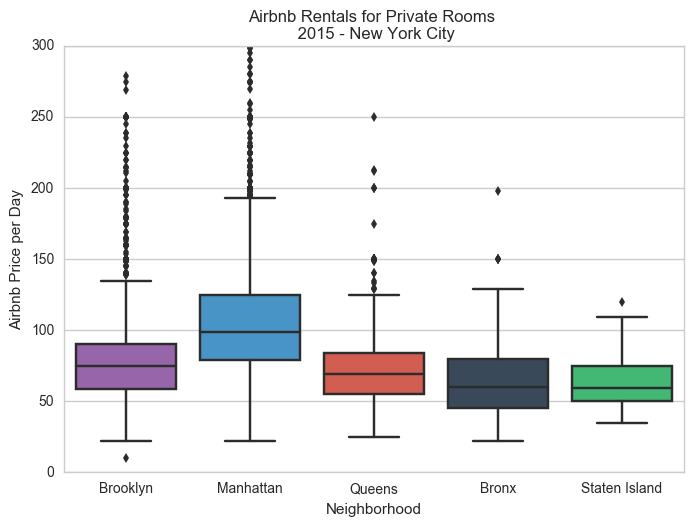

In [116]:
sns.set(style="whitegrid", 
        color_codes=True)

# Manually set color palette
col = ["#9b59b6", "#3498db", "#e74c3c", "#34495e", "#2ecc71"]

# Plot graph
sns.boxplot(x="borough", 
            y="day_price", 
            data=Rent_Private,
            palette=col)

# Add title and labels
plt.title('Airbnb Rentals for Private Rooms \n 2015 - New York City')
plt.xlabel('Neighborhood')
plt.ylabel('Airbnb Price per Day')

Not suprisingly, Manhattan has the most expensive rentals in NYC.

#### StripPlot of Daily Prices by Neighborhoods in Manhattan

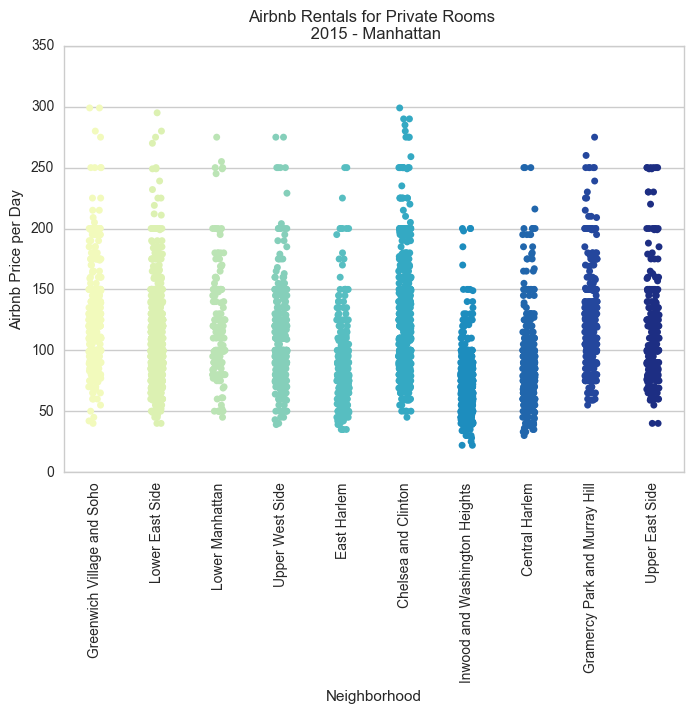

In [115]:
# Plot graph
g = sns.stripplot(x="Neighborhood", 
              y="day_price", 
              data=Rent_Private[Rent_Private['borough'] == 'Manhattan'],
              palette='YlGnBu',
              jitter=True);

# rotate labels 90 degrees
for item in g.get_xticklabels():
    item.set_rotation(90)

# Add title and labels
plt.title('Airbnb Rentals for Private Rooms \n 2015 - Manhattan')
plt.xlabel('Neighborhood')
plt.ylabel('Airbnb Price per Day')

Within Manhattan, Chelseas seems to have the most expensive rentals

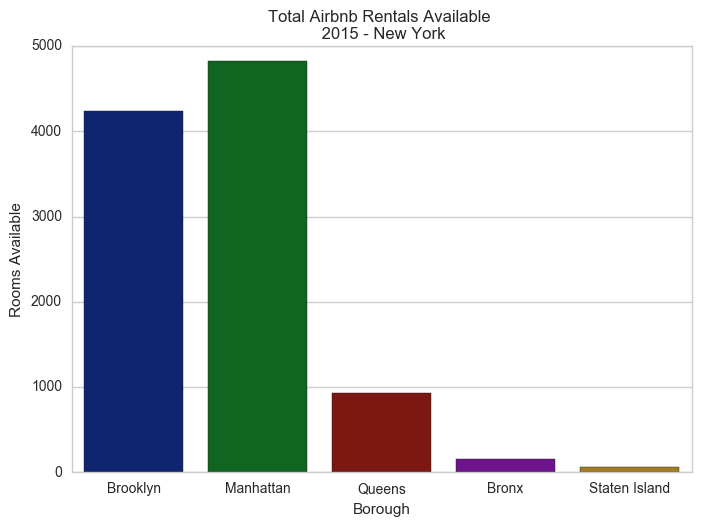

In [108]:
# Plot bar chart with total rentals available by Borough
sns.countplot(x="borough", 
              data=Rent_Private,
              palette='dark')

# Add title and lables
plt.title('Total Airbnb Rentals Available \n 2015 - New York')
plt.xlabel('Borough')
plt.ylabel('Rooms Available')

### 3.2 Housing Data vs Crime Data

#### Average Price for Private Rooms Grouped by Neighborhood

In [54]:
Price_Neighborhood=Rent_Private.groupby(by=['Neighborhood'],as_index=False)['day_price'].mean()
Price_Neighborhood.head(2)

,Neighborhood,day_price
0,Borough Park,70.389381
1,Bronx Park and Fordham,65.736842


#### Total Number of Apartments Available in New York Grouped by Neighborhood

In [55]:
# New table with total number of rentals available
Total_Neighborhood=Rent_Private.groupby(by=['Neighborhood'],as_index=False)['day_price'].count()
Total_Neighborhood.rename(columns={'day_price': 'Total'}, inplace=True)
Total_Neighborhood.head(2)

,Neighborhood,Total
0,Borough Park,113
1,Bronx Park and Fordham,19


#### Total Number of Crimes Grouped by Neighborhood

In [56]:
Crime_Neighborhood=Crime_Total.groupby(by=['Neighborhood'],as_index=False)['YTD_Current'].sum()
Crime_Neighborhood.head(2)

,Neighborhood,YTD_Current
0,Borough Park,997
1,Bronx Park and Fordham,4209


#### Merge the three tables to get Average Price,Total Crimes and Total Apartments on the same table

In [102]:
# Create New table with merged data from three dataframes
Combined = pd.merge(pd.merge(Price_Neighborhood,Crime_Neighborhood,how='inner',on='Neighborhood'),
                     Total_Neighborhood,how='inner',on='Neighborhood')
labels=Combined['Neighborhood'].tolist()

Combined.head(2)

,Neighborhood,day_price,YTD_Current,Total
0,Borough Park,70.389381,997,113
1,Bronx Park and Fordham,65.736842,4209,19


#### Plot Average Price by Total Crimes, with Total Apartments as the size of the markers

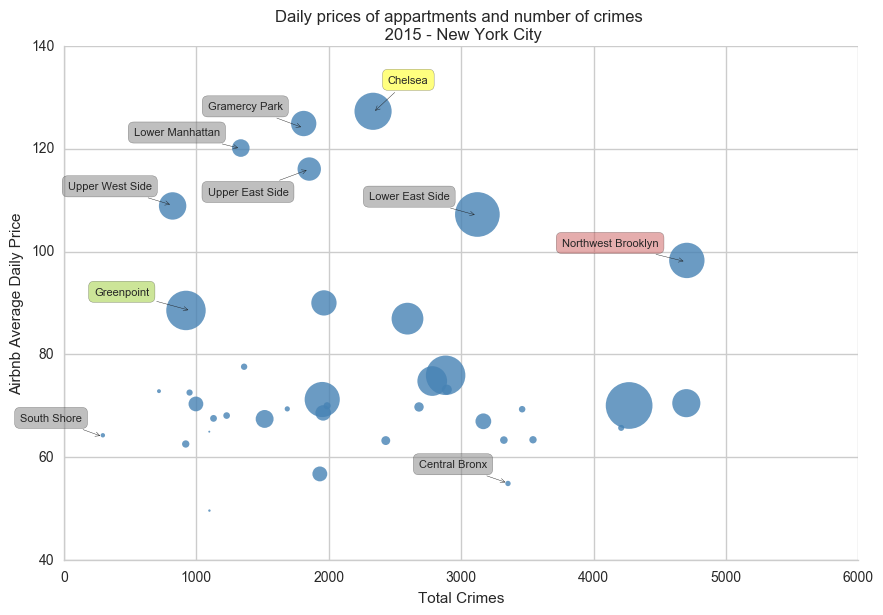

In [101]:
sns.set(style="whitegrid", 
        color_codes=True)

# Plot graph
g = sns.lmplot('YTD_Current', 'day_price',
           data=Combined,
           fit_reg=False,
           scatter=True,
           palette="Red",
           size = 6,
           aspect = 1.5,
           scatter_kws={"marker": "D", "s": Combined.Total,"color": "steelblue"})


# Annotate some Neighborhoods based on their data coordinates
plt.annotate('Lower East Side', xy=(3123,107), xytext = (-20, 10), xycoords = 'data',
                    textcoords = 'offset points', ha = 'right', va = 'bottom', fontsize=8,
                    bbox = dict(boxstyle = 'round,pad=0.5', fc = 'grey', alpha = 0.5),
                    arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.annotate('Chelsea', xy=(2335,127), xytext = (40, 20), xycoords = 'data',
                    textcoords = 'offset points', ha = 'right', va = 'bottom', fontsize=8,
                    bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
                    arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.annotate('Gramercy Park', xy=(1811,124), xytext = (-15, 12), xycoords = 'data',
                    textcoords = 'offset points', ha = 'right', va = 'bottom', fontsize=8,
                    bbox = dict(boxstyle = 'round,pad=0.5', fc = 'grey', alpha = 0.5),
                    arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.annotate('Greenpoint', xy=(960,88.5), xytext = (-30, 10), xycoords = 'data',
                    textcoords = 'offset points', ha = 'right', va = 'bottom', fontsize=8,
                    bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellowgreen', alpha = 0.5),
                    arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.annotate('Northwest Brooklyn', xy=(4700,98), xytext = (-20, 10), xycoords = 'data',
                    textcoords = 'offset points', ha = 'right', va = 'bottom', fontsize=8,
                    bbox = dict(boxstyle = 'round,pad=0.5', fc = 'indianred', alpha = 0.5),
                    arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.annotate('Upper East Side', xy=(1853,116), xytext = (-15, -20), xycoords = 'data',
                    textcoords = 'offset points', ha = 'right', va = 'bottom', fontsize=8,
                    bbox = dict(boxstyle = 'round,pad=0.5', fc = 'grey', alpha = 0.5),
                    arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.annotate('Upper West Side', xy=(821,109), xytext = (-15, 10), xycoords = 'data',
                    textcoords = 'offset points', ha = 'right', va = 'bottom', fontsize=8,
                    bbox = dict(boxstyle = 'round,pad=0.5', fc = 'grey', alpha = 0.5),
                    arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
plt.annotate('Central Bronx', xy=(3354,55), xytext = (-15, 10), xycoords = 'data',
                    textcoords = 'offset points', ha = 'right', va = 'bottom', fontsize=8,
                    bbox = dict(boxstyle = 'round,pad=0.5', fc = 'grey', alpha = 0.5),
                    arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
plt.annotate('Lower Manhattan', xy=(1336,120), xytext = (-15, 8), xycoords = 'data',
                    textcoords = 'offset points', ha = 'right', va = 'bottom', fontsize=8,
                    bbox = dict(boxstyle = 'round,pad=0.5', fc = 'grey', alpha = 0.5),
                    arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
plt.annotate('South Shore', xy=(294,64), xytext = (-15, 10), xycoords = 'data',
                    textcoords = 'offset points', ha = 'right', va = 'bottom', fontsize=8,
                    bbox = dict(boxstyle = 'round,pad=0.5', fc = 'grey', alpha = 0.5),
                    arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))


# Add title and labels
plt.title('Daily prices of appartments and number of crimes \n 2015 - New York City')
plt.xlabel('Total Crimes')
plt.ylabel('Airbnb Average Daily Price')

We can point out a few outliers from this graph:

1) Northwest Brooklyn has a high crime rate and also a relatevily high average daily price

2) Chelsea has the highest average daily price, and also a median cime rate

3) Greenpoint seems like a good neighborhood. Low crime rate and also a low daily price

### 4. Conclusion

As said in the introduction, rent prices is a function of several factors. Undoubtly, crime is one of those factors. Even though we were not able to see a specific pattern in the Airbnb prices with relation to crime rates, I think we were able to point out a few outliers. Unfortunetely, the neighborhoods areas are not the same size, so looking at total crimes is not a fair assesment when comparing different areas. We would probably need to look at total crime divided by population to get a more accurate picture. For example, according to this data, Greenpoint neighborhood has a very low crime rate and a reasonably affordable rent. In contrast, the area called Northwest Brooklyn (Which is actually the area of Brooklyn Hights, Park Slope, Bed-Stuy, Williamsberg, and Redhook) has a high crime rate. There areas are actually very close to each other, but Northwest Brookly is a much larger area. 

